Fat T$_1$ = 365 ms,  T$_2$ = 80 ms

Water T$_1$ = 1400 ms T$_2$ = 35 ms


Benjamin Marty et al., Simultaneous muscle water T$_2$ and fat fraction mapping using transverse relaxometry with stimulated echo compensation, *NMR Biomed*. 2016; **29**: p431–443.

In [1]:
from __future__ import print_function

In [2]:
import guidata
_app = guidata.qapplication() # not required if a QApplication has already been created

import guidata.dataset.datatypes as dt
import guidata.dataset.dataitems as di

#import  matlab.engine

In [3]:
from epg import cpmg_epg as cpmg_epg_c
import time

In [6]:
import os
import sys
from string import Template
import ijroi
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import axes3d
from matplotlib import pyplot as plt

import lmfit as lm
#import cpmg_epg_hargreaves1 as epg

import seaborn as sns
import nibabel

import collections
from scipy import stats
from scipy import integrate

from IPython.display import display, Markdown, Latex

from skimage.draw import (line, polygon, circle,
                          circle_perimeter,
                          ellipse, ellipse_perimeter,
                          bezier_curve)

%matplotlib  inline

c:\users\neh69\appdata\local\continuum\anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [7]:
def extract_display_t2_error_parameters2(df, num_rows, num_cols):
   
    image1 = np.zeros(num_cols*num_rows)
    image2 = np.zeros(num_cols*num_rows)
   
    for i in df.index:
       k = df['pixel_index'][i]
       image1[k] =df['T2value'][i]
       
    
    for i in df.index:
       k = df['pixel_index'][i]
       image2[k] =df['T2stderr'][i]

    return(image1.reshape(num_rows,num_cols),image2.reshape(num_rows,num_cols))


In [8]:
#eng = matlab.engine.start_matlab()

In [9]:
class workingDirectories(dt.DataSet):
    """Set working processed directory"""
    #/media/eric/70DA58715E6C32A6/visionDMD/processed_data/newcastle_test
    #procDatadir = di.DirectoryItem("Processed Data Directory", 'W:/processed_data/Newcastle_test')
    procDatadir = di.DirectoryItem("Processed Data Directory", '/media/eric/70DA58715E6C32A6/visionDMD/processed_data/newcastle_test')
    

In [10]:
wDirs = workingDirectories()

In [11]:
wDirs.edit()

1

In [114]:
mxyz90 = np.fromfile( 'mxyz90.txt', sep=' ' )
mxyz180 = np.fromfile('mxyz180.txt', sep=' ')

mxyz90 = mxyz90.reshape(5,512)
mxyz180 = mxyz180.reshape(5,512)

offset=130
step=10
slice_xxx =mxyz90[0][offset:-offset+step:step] # mm
p90 = mxyz90[-1][offset:-offset+step:step]     # degrees
p180 = mxyz180[-1][offset:-offset+step:step]   # degrees

In [13]:
root_dir_structure = '/media/eric/70DA58715E6C32A6/visionDMD'
root_dir_structure = 'w:'

In [14]:
#[drive, subdir, mri_site, data_filename] = procDataDirList = wDirs.procDatadir.split('/')
procDataDirList = wDirs.procDatadir.split('/')

data_filename = procDataDirList[-1]
mri_site = procDataDirList[-2]
subdir = procDataDirList[-3]
procDataDirList

['W:', 'processed_data', 'Newcastle_test', '2801LW_H_01aug2017']

In [15]:
print( data_filename, mri_site, subdir)

2801LW_H_01aug2017 Newcastle_test processed_data


In [16]:
studyDataDirList = [root_dir_structure, 'study_data', mri_site, data_filename]

In [17]:
studyDataDir =  '/'.join(studyDataDirList)

In [18]:
studyDataDir

'w:/study_data/Newcastle_test/2801LW_H_01aug2017'

In [19]:
procDataDirList = [root_dir_structure, 'processed_data', mri_site, data_filename]
procDataDir = '/'.join(procDataDirList)

In [20]:
procDataDir

'w:/processed_data/Newcastle_test/2801LW_H_01aug2017'

In [21]:
procDataResultsDirList = [root_dir_structure, 'processed_data', mri_site, data_filename, 'Results']


In [22]:
procDataResultsDirList

['w:', 'processed_data', 'Newcastle_test', '2801LW_H_01aug2017', 'Results']

In [23]:
procDataResultsDir = '/'.join(procDataResultsDirList)
procDataResultsDir

if not os.path.exists(procDataResultsDir):
    os.makedirs(procDataResultsDir)

In [24]:
roiList = [s for s in os.listdir(procDataDir) if "zip" in s]
roiList

['RoiSet_UL_slice0.zip',
 'RoiSet_UL_slice1.zip',
 'RoiSet_UL_slice2.zip',
 'RoiSet_UL_slice3.zip',
 'RoiSet_UL_slice4.zip']

In [25]:
filename_hdr = procDataDir+'//'+ 'WIP_T2_multiecho_UL_CLEAR' + '.hdr'
filename_img = procDataDir+'//'+ 'WIP_T2_multiecho_UL_CLEAR' + '.img'
hdr = nibabel.load(filename_hdr)
img = nibabel.load(filename_img)
    
imageDataT2 = img.get_data()
imageDataT2.shape
    

(256, 256, 5, 17)

w:/processed_data/Newcastle_test/2801LW_H_01aug2017//WIP_T2_multiecho_UL_CLEAR.hdr


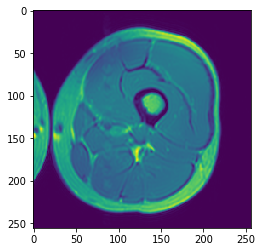

In [26]:
slice_number = 2
(numRowsT2, numColsT2, numSlicesT2, numEchoesT2) = imageDataT2.shape
print(filename_hdr)
plt.imshow(np.rot90(imageDataT2[:,:,slice_number,0]))

### Isolate Fat

In [27]:
# #extract header file and slice files
# headerList = [k for k in store.keys() if 'header' in k]
# summaryList = [k for k in store.keys() if 'summary' in k]
imageDataT2_rot90 = np.flipud(imageDataT2.swapaxes(1,0))


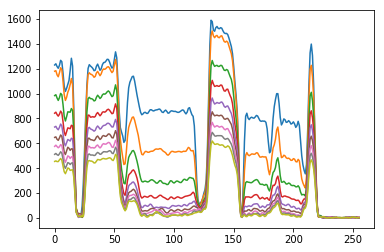

In [28]:
plt.plot(imageDataT2_rot90[110,:,slice_number,0]);
plt.plot(imageDataT2_rot90[110,:,slice_number,2]);
plt.plot(imageDataT2_rot90[110,:,slice_number,4]);
plt.plot(imageDataT2_rot90[110,:,slice_number,6]);
plt.plot(imageDataT2_rot90[110,:,slice_number,8]);
plt.plot(imageDataT2_rot90[110,:,slice_number,10]);
plt.plot(imageDataT2_rot90[110,:,slice_number,12]);
plt.plot(imageDataT2_rot90[110,:,slice_number,14]);
plt.plot(imageDataT2_rot90[110,:,slice_number,16]);
#plt.plot(imageDataT2_rot90[:,254,slice_number,0]);

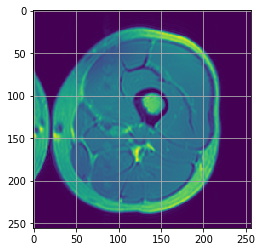

In [29]:
plt.imshow(imageDataT2_rot90[:,:,slice_number,0])
plt.grid()

In [30]:
print( "Max value in image slice =",imageDataT2_rot90[:,:,slice_number,0].max() )
print( "Min value in image slice =",imageDataT2_rot90[:,:,slice_number,0].min() )

Max value in image slice = 2039.4265837669373
Min value in image slice = 0.0


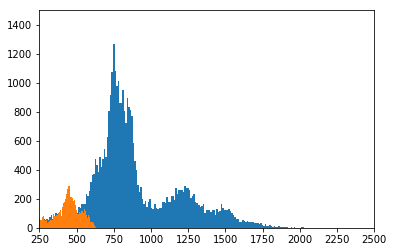

In [31]:
plt.hist(imageDataT2_rot90[:,:,slice_number,0].flatten(), bins=200);
plt.hist(imageDataT2_rot90[:,:,slice_number,16].flatten(), bins=200);
plt.xlim(250,2500);
plt.ylim(0,1500);

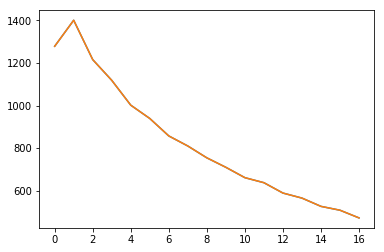

In [32]:
plt.plot((imageDataT2_rot90[125,30,slice_number,:]))
plt.plot((imageDataT2_rot90[125,30,slice_number,:]))

In [33]:
print( "slope fat = ", imageDataT2_rot90[125,30,slice_number,1]-imageDataT2_rot90[125,30,slice_number,16])

slope fat =  928.0224509239197


In [34]:
print( "slope muscle = ", imageDataT2_rot90[200,75,slice_number,1]-imageDataT2_rot90[200,75,slice_number,16])

slope muscle =  565.4268525838852


In [35]:
img_mask = np.zeros((256,256))
img_slope = np.zeros((256,256))
for i in range(256):
    for j in range(256):
        slope = imageDataT2_rot90[i,j,slice_number,0]-imageDataT2_rot90[i,j,slice_number,16]
        img_slope[i,j] = slope
        if imageDataT2_rot90[i,j,slice_number,1] > 900:
            img_mask[i,j] = 1

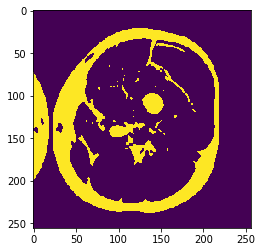

In [36]:
plt.imshow(img_mask)

In [37]:
img_bool = imageDataT2_rot90[:,:,slice_number,1] > 900

In [38]:
img_bool.shape

(256, 256)

In [39]:
img_mask = img_bool*imageDataT2_rot90[:,:,slice_number,0]

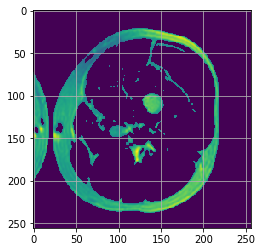

In [40]:
plt.imshow(img_mask)
plt.grid()

In [41]:
imageDataT2_rot90.shape

(256, 256, 5, 17)

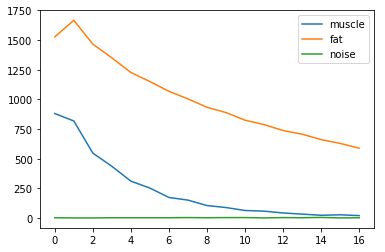

In [42]:
# header_df = store.get(headerList[0])
#plt.plot((imageDataT2_rot90[200,75,slice_number,:]))
plt.plot((imageDataT2_rot90[60,175,slice_number,:]), label='muscle')
plt.plot((imageDataT2_rot90[110,140,slice_number,:]), label='fat')
plt.plot((imageDataT2_rot90[225,225,slice_number,:]), label='noise')
plt.legend();

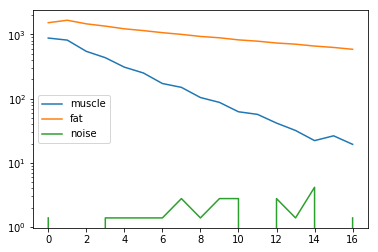

In [43]:
plt.semilogy((imageDataT2_rot90[60,175,slice_number,:]), label='muscle')
plt.semilogy((imageDataT2_rot90[110,140,slice_number,:]), label='fat')
plt.semilogy((imageDataT2_rot90[225,225,slice_number,:]), label='noise')
plt.legend();

In [156]:
N_in = 17.
alpha_in =121.
ESP_in = 10.24
T1_in = 365. # T1 fat
T2_in = 50.
A_in = 2000.

In [157]:
xxx = np.arange(ESP_in, (N_in+1)*ESP_in, ESP_in)
xxx

array([ 10.24,  20.48,  30.72,  40.96,  51.2 ,  61.44,  71.68,  81.92,
        92.16, 102.4 , 112.64, 122.88, 133.12, 143.36, 153.6 , 163.84,
       174.08])

In [158]:
#xxx1 = matlab.double(xxx)

In [159]:
#yyy_data = imageDataT2_rot90[60,175,slice_number,:]
#yyy_data = imageDataT2_rot90[125,30,slice_number,:]

yyy_fat = imageDataT2_rot90[110,140,slice_number,:]
yyy_muscle = imageDataT2_rot90[60,175,slice_number,:]

In [160]:
yyy_fat_norm = yyy_fat/yyy_fat.max()
yyy_muscle_norm = yyy_muscle/yyy_muscle.max()

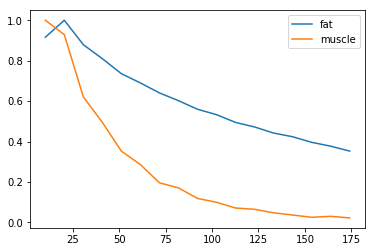

In [161]:
plt.plot(xxx,yyy_fat_norm, label='fat')
plt.plot(xxx,yyy_muscle_norm, label= 'muscle')
plt.legend()

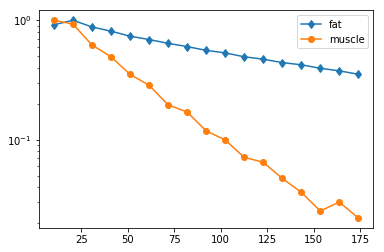

In [162]:
plt.semilogy(xxx,yyy_fat_norm, 'd-', label='fat')
plt.semilogy(xxx,yyy_muscle_norm, 'o-',label= 'muscle')
plt.legend()

In [163]:
def  epg_grad(FpFmZ, noadd=0):
    if noadd == 0:
        FpFmZ = np.concatenate((FpFmZ,np.zeros((3,1))), axis=1)
        
    FpFmZ[0,:] = np.roll(FpFmZ[0,:], 1)
    FpFmZ[1,:] = np.roll(FpFmZ[1,:],-1)
    FpFmZ[1,-1] = 0
    FpFmZ[0,0] = np.conjugate(FpFmZ[1,0])
    
    return(FpFmZ)
    
  
def epg_grelax( FpFmZ, T1, T2, T, kg = 0, D = 0, Gon = 1, noadd = 0):
    
    E1 = np.exp(-T/2.0/T1)
    E2 = np.exp(-T/2.0/T2)
    
    EE = np.diag([E2, E2, E1])
    RR = 1.0-E1
    
    FpFmZ = np.dot( EE, FpFmZ)
    
    FpFmZ[2,0] = FpFmZ[2,0]+RR
    
#     print(EE)
#     print('RR=',RR)
#     print('FpFmZ=\n',FpFmZ[:,:4].real)
    
    ##Assume Gradient is on and kg >= 0
    
    FpFmZ = epg_grad(FpFmZ, noadd)
    
    
    return(FpFmZ)


def  epg_rf( FpFmZ, alpha, phi ):
    
    RR = np.zeros((3,3), dtype = np.complex128)
    
    RR[0,0] = np.cos(alpha/2.)**2
    RR[0,1] = np.exp(2.0*1j*phi)*(np.sin(alpha/2.0))**2
    RR[0,2] = -1j*np.exp(1j*phi)*np.sin(alpha)
    
    RR[1,0] = np.exp(-2j*phi)*(np.sin(alpha/2.0))**2
    RR[1,1] = (np.cos(alpha/2.0))**2
    RR[1,2] = 1j*np.exp(-1j*phi)*np.sin(alpha)
    
    RR[2,0] = (-1j/2.0)*np.exp(-1j*phi)*np.sin(alpha)
    RR[2,1] = ( 1j/2.0)*np.exp( 1j*phi)*np.sin(alpha)
    RR[2,2] = np.cos(alpha)
    
    FpFmZ = np.dot(RR, FpFmZ)
    
    return( FpFmZ, RR)


def  rf_pulse( alpha, phi ):
    
    RR = np.zeros((3,3), dtype = np.complex128)
    
    RR[0,0] = np.cos(alpha/2.)**2
    RR[0,1] = np.exp(2.0*1j*phi)*(np.sin(alpha/2.0))**2
    RR[0,2] = -1j*np.exp(1j*phi)*np.sin(alpha)
    
    RR[1,0] = np.exp(-2j*phi)*(np.sin(alpha/2.0))**2
    RR[1,1] = (np.cos(alpha/2.0))**2
    RR[1,2] = 1j*np.exp(-1j*phi)*np.sin(alpha)
    
    RR[2,0] = (-1j/2.0)*np.exp(-1j*phi)*np.sin(alpha)
    RR[2,1] = ( 1j/2.0)*np.exp( 1j*phi)*np.sin(alpha)
    RR[2,2] = np.cos(alpha)
    
    return(RR)


def cpmg_epg_py( Nechos=17, rf_180=120.0, T1=3000.0, T2=50.0, Techo=10.0 ):
	

    P = np.zeros((3,2*Nechos),dtype=np.complex128)
    
    P[0,0] = 0.0  # Fp
    P[1,0] = 0.0  # Fm
    P[2,0] = 1.0  # Z
    
    signal = np.zeros(Nechos)
    
    rf_pulse90_rad = np.pi*rf_180/360.
    
    rf_pulse_rad = np.pi*rf_180/180.
    
    RR90  = rf_pulse(rf_pulse90_rad, np.pi/2.0)
    RR180 = rf_pulse(rf_pulse_rad,   0.0)
    
    P = np.dot(RR90,P)
    #signal[0] = P[0,0].real
    
    for echo in range(Nechos):
        P = epg_grelax( P, T1, T2, Techo)
        P = np.dot(RR180,P)
        P = epg_grelax( P, T1, T2, Techo)
        
        signal[echo] = (P[0,0].real)
        
    return(signal)

In [164]:
def fit_cpmg_epg_muscle_philips_hargreaves_c( params,  xxx,  p90_array, p180_array, yyy_exp=None):
    
    parvals  = params.valuesdict()
    

    
    T1fat    = parvals[ 'T1fat' ]      # fixed
    T1muscle = parvals[ 'T1muscle' ]      # fixed
    echo     = parvals[ 'echo' ]     # fixed
    b1_scale = parvals['b1_scale']   # optimized
    T2fat    = parvals[ 'T2fat' ]     # fixed
    T2muscle = parvals['T2muscle']       # optimized
    Afat     = parvals[ 'Afat']       # optimized
    Amuscle = parvals['Amuscle']        # optimized
    
    Nechos = len(xxx)
    Ngauss = len(p90_array)
    signal = np.zeros([Ngauss,Nechos])
    signal1 = np.zeros(Nechos)
    signal2 = np.zeros(Nechos)
    
    for i,(p90,p180) in enumerate(zip(p90_array,p180_array)):
        #print(i,g, pi_pulse*g)
        cpmg_epg_c( signal1, p90*b1_scale, p180*b1_scale, T1fat,    T2fat,    echo )
        cpmg_epg_c( signal2, p90*b1_scale, p180*b1_scale, T1muscle, T2muscle, echo )
        signal[i] = Afat*signal1+Amuscle*signal2
        
    int_signal = integrate.simps(signal, dx=1./(Ngauss-1),axis=0)
    if isinstance(yyy_exp, np.ndarray):   
        return( int_signal-yyy_exp)
    else:
        return(int_signal) 

### Analyze muscle

In [165]:
signal = np.zeros([21,17])
signal1 = np.zeros(17)
signal2 = np.zeros(17)

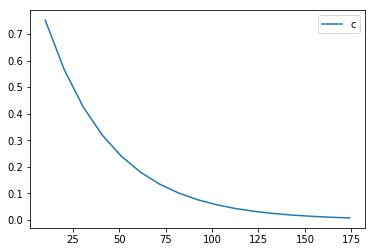

In [166]:
signal_c = np.zeros(17)
cpmg_epg_c( signal_c, 90.0,180.0, 3000, 35.0, 10.)
plt.plot(xxx,signal_c, label='c');
plt.legend();

In [167]:
params = lm.Parameters()
params.add('b1_scale',   value= 1.0,  min=0, max=5.0, vary=True)
params.add('T2fat', value = 180.0, min=0, max=1000, vary=True)
params.add('T2muscle', value = 35, min=0, max=100, vary=True)
params.add('Afat', value = 1.0,  min=0, max=10, vary=True)
params.add('Amuscle', value = 3,  min=0, max=10, vary=True)
params.add('T1fat', value = 365.0, vary=False)
params.add('T1muscle', value = 1400, vary=False)
params.add('echo', value = 10.0, vary=False)

yyy_guess_integral_c  = fit_cpmg_epg_muscle_philips_hargreaves_c( params,  xxx,  p90, p180)

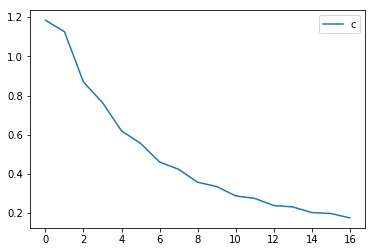

In [168]:
plt.plot(yyy_guess_integral_c, label='c');
plt.legend();

In [169]:
xxx

array([ 10.24,  20.48,  30.72,  40.96,  51.2 ,  61.44,  71.68,  81.92,
        92.16, 102.4 , 112.64, 122.88, 133.12, 143.36, 153.6 , 163.84,
       174.08])

In [170]:
# params = lm.Parameters()
# params.add('b1_scale',   value= 1.0,  min=0, max=5.0, vary=True)
# params.add('T2fat', value = 180.0, min=0, max=1000, vary=True)
# params.add('T2muscle', value = 35, min=0, max=100, vary=True)
# params.add('Afat', value = 1.0,  min=0, max=10, vary=True)
# params.add('Amuscle', value = 3,  min=0, max=10, vary=True)
# params.add('T1fat', value = 365.0, vary=False)
# params.add('T1muscle', value = 1400, vary=False)
# params.add('echo', value = 10.0, vary=False)

#xxx = np.arange(Techo, Techo*(et1+1))
minner  = lm.Minimizer(fit_cpmg_epg_muscle_philips_hargreaves_c, params, fcn_args=( xxx, p90, p180, yyy_data))

yyy_guess_integral = fit_cpmg_epg_muscle_philips_hargreaves_c( params,  xxx, p90, p180) 
yyy_fit_integral = fit_cpmg_epg_muscle_philips_hargreaves_c( result.params,  xxx, p90, p180) 

t_start = time.time()
result = minner.minimize()
t_end = time.time()

time_c = t_end-t_start
print(time_c)

lm.report_fit(result.params)

0.13000011444091797
[[Variables]]
    b1_scale:   0.96644982 +/- 0.017700 (1.83%) (init= 1)
    T2fat:      999.997127 +/- 6.84e+03 (684.49%) (init= 180)
    T2muscle:   31.7339502 +/- 1.616374 (5.09%) (init= 35)
    Afat:       0.10139062 +/- 0.106763 (105.30%) (init= 1)
    Amuscle:    3.72834338 +/- 0.097030 (2.60%) (init= 3)
    T1fat:      365 (fixed)
    T1muscle:   1400 (fixed)
    echo:       10 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(T2fat, Afat)               = -0.993 
    C(T2muscle, Afat)            = -0.942 
    C(T2fat, T2muscle)           =  0.909 
    C(b1_scale, Amuscle)         = -0.586 
    C(T2fat, Amuscle)            =  0.579 
    C(Afat, Amuscle)             = -0.544 
    C(b1_scale, T2muscle)        =  0.437 
    C(T2muscle, Amuscle)         =  0.275 
    C(b1_scale, Afat)            = -0.257 
    C(b1_scale, T2fat)           =  0.229 


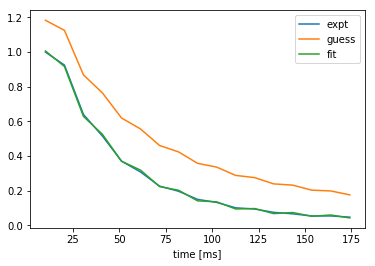

In [171]:
plt.plot(xxx,yyy_data, label='expt');
plt.plot(xxx,yyy_guess_integral, label='guess');
plt.plot(xxx,yyy_fit_integral, label='fit');
plt.xlabel('time [ms]');
plt.legend();

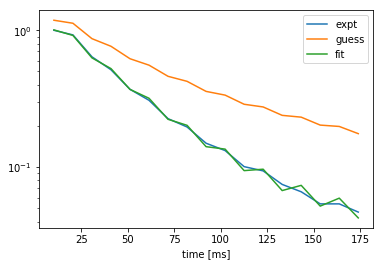

In [172]:
plt.semilogy(xxx,yyy_data, label='expt');
plt.semilogy(xxx,yyy_guess_integral, label='guess');
plt.semilogy(xxx,yyy_fit_integral, label='fit');
plt.xlabel('time [ms]');
plt.legend();

In [173]:
print(dir(result))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'aborted', 'aic', 'bic', 'chisqr', 'covar', 'errorbars', 'fjac', 'flatchain', 'ier', 'init_vals', 'init_values', 'lmdif_message', 'message', 'method', 'ndata', 'nfev', 'nfree', 'nvarys', 'params', 'redchi', 'residual', 'show_candidates', 'success', 'var_names']


In [174]:
result.success

True

In [175]:
roiList

['RoiSet_UL_slice0.zip',
 'RoiSet_UL_slice1.zip',
 'RoiSet_UL_slice2.zip',
 'RoiSet_UL_slice3.zip',
 'RoiSet_UL_slice4.zip']

In [176]:
roi_filename = 'RoiSet_UL_slice' + str(slice_number) +'.zip'

In [177]:
startpos = roi_filename.rfind("slice")
slice_num = roi_filename[startpos:startpos+len("slice")+1]
print('slice_num', slice_num)

slice_num slice2


In [178]:
roi_set = ijroi.read_roi_zip(procDataDir+'//'+roi_filename)

In [179]:
img = np.zeros((numRowsT2,numColsT2),dtype=np.bool)

for roi in roi_set:
    (roiName,(roiShape,coords))=roi
    print("roiName: ", roiName,"roiShape: ",roiShape)

    if roiShape == 'polygon':        
        coords=coords.transpose()
        xxxc = coords[0]
        yyyc = coords[1]
        (rr,cc) = polygon(xxxc,yyyc)
        img[rr, cc] = True
        #roi_x = img_index[img.flatten()]

    elif roiShape == 'rect':        
        coords=coords.transpose()
        xxxc = coords[0]
        yyyc = coords[1]
        (rr,cc) = polygon(xxxc,yyyc)
        img[rr, cc] = True
        #roi_x = img_index[img.flatten()]

    elif roiShape == 'oval':
        xc = coords[0][0]
        yc = coords[0][1]
        xr = coords[1][0]
        yr = coords[1][1]
        (rr,cc) = ellipse(yc,xc,yr,xr)
        img[rr, cc] = True
        #roi_x = img_index[img.flatten()]
    #t2m_i[rr,cc]=1

roiName:  VL_s0_vastus_lateralis.roi roiShape:  polygon
roiName:  BL_s0_biceps_femoris.roi roiShape:  polygon


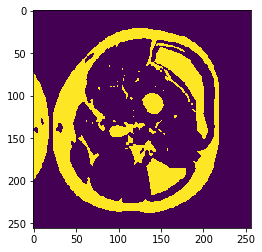

In [180]:
plt.imshow(img_bool+img);

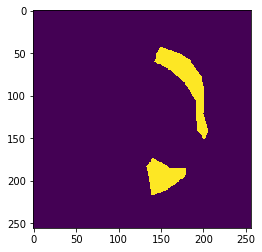

In [181]:
plt.imshow(img);

In [183]:
# params = lm.Parameters()
# params.add('b1_scale',   value= 1.0,  min=0, max=5.0, vary=True)
# params.add('T2fat', value = 180.0, min=0, max=1000, vary=True)
# params.add('T2muscle', value = 35, min=0, max=100, vary=True)
# params.add('Afat', value = 0.5,  min=0, max=10, vary=True)
# params.add('Amuscle', value = 3,  min=0, max=10, vary=True)
# params.add('T1fat', value = 365.0, vary=False)
# params.add('T1muscle', value = 1400, vary=False)
# params.add('echo', value = 10.0, vary=False)

et1 = 17
Techo = params['echo']

xxx = np.arange(Techo, Techo*(et1+1),Techo)

t_start=time.time()

k=0
epg_results = {}
for i in range(numRowsT2):
    print (i, end= " ")
    for j in range(numColsT2):
        if img[i,j]:
            k +=1
            
            yyy_data = imageDataT2_rot90[i,j,slice_number,:]
            yyy_data = yyy_data/yyy_data.max()
            
            minner = lm.Minimizer(fit_cpmg_epg_muscle_philips_hargreaves_c, params, fcn_args=( xxx, p90, p180, yyy_data))
            #minner = lm.Minimizer(fit_cpmg_epg_muscle_gauss_hargreaves_c, params, fcn_args=( xxx,signal, signal1, signal2,yyy_data))
            
            result = minner.minimize()

            if result.success:
                epg_results[(i,j)]=[result.params['b1_scale'].value,
                                    result.params['T2fat'].value,
                                    result.params['T2muscle'].value,
                                    result.params['Afat'].value,
                                    result.params['Amuscle'].value]
print(k)
t_end = time.time()

time_c = t_end-t_start
print (time_c)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 3189
367.0901622772217


In [184]:
vals = epg_results.values()
    

In [185]:
epg_vals = np.zeros((len(vals),5))

In [186]:
for i,v in enumerate(vals):
    epg_vals[i]= v

In [187]:
epg_vals.shape

(3189, 5)

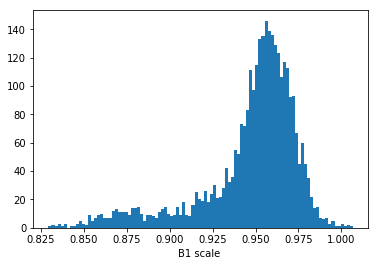

In [188]:
plt.hist(epg_vals[:,0], bins=100);
plt.xlabel('B1 scale ');
#plt.xlim([0,270]);
#plt.savefig('png_images/muscle_angles.png');

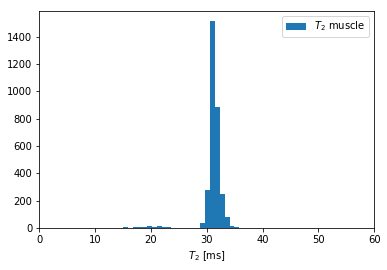

In [208]:
fig, axes = plt.subplots(nrows=1, ncols=1)

axes.hist(epg_vals[:,2], bins=100, label='$T_2$ muscle');
#axes.set_xlim(0,200);
#axes[1].hist(epg_vals[:,4], bins=100, label='T2f2');
axes.set_xlabel('$T_2$ [ms]');
axes.set_xlim(0,60)
#axes[1].set_xlabel('$T_2$ [ms]');
axes.legend();
#axes[1].legend();
#plt.savefig('png_images/muscle_T2.png');

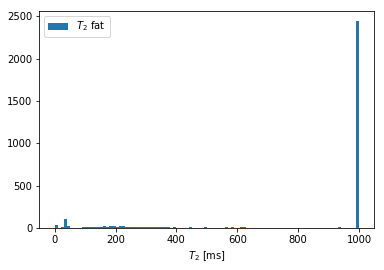

In [202]:
fig, axes = plt.subplots(nrows=1, ncols=1)

axes.hist(epg_vals[:,1], bins=100, label='$T_2$ fat');
#axes.set_xlim(0,200);
#axes[1].hist(epg_vals[:,4], bins=100, label='T2f2');
axes.set_xlabel('$T_2$ [ms]');
#axes[1].set_xlabel('$T_2$ [ms]');
axes.legend();
#axes[1].legend();
#plt.savefig('png_images/muscle_T2.png');

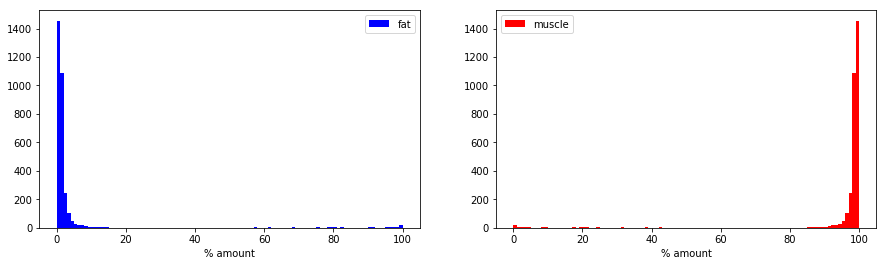

In [203]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

af1 = epg_vals[:,3]*100/(epg_vals[:,3]+epg_vals[:,4])
af2 = 100-af1

axes[0].hist(af1, color='blue', bins=100, label='fat');
axes[1].hist(af2, color='red', bins=100, label='muscle');
#axes[2].hist(epg_vals[:,3], color='green', bins=100, label='af3');
axes[0].set_xlabel('% amount');
axes[1].set_xlabel('% amount');
#axes[2].set_xlabel('amount');
axes[0].legend()
axes[1].legend()
#axes[2].legend()
#plt.savefig('png_images/muscle_amount.png');

In [192]:
t2muscle_image = np.zeros((numRowsT2,numColsT2))
t2fat_image = np.zeros((numRowsT2,numColsT2))
Amuscle_image = np.zeros((numRowsT2,numColsT2))
b1scale_image = np.zeros((numRowsT2,numColsT2))
Afat_image = np.zeros((numRowsT2,numColsT2))

In [205]:
for (x,y),vv in epg_results.items():

        b1scale_image[x,y] = vv[0]
        t2fat_image[x,y] = vv[1]
        t2muscle_image[x,y] = vv[2]
        Amuscle_image[x,y] = vv[3]
        Afat_image[x,y] = vv[4]

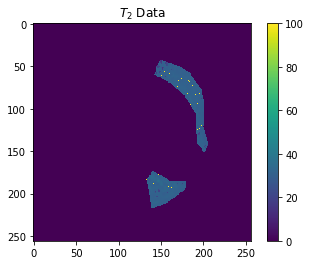

In [206]:
plt.imshow(t2muscle_image);
plt.title('$T_2$ Data');
plt.colorbar();
#plt.savefig('png_images/muscle_T2f1_imag.png');

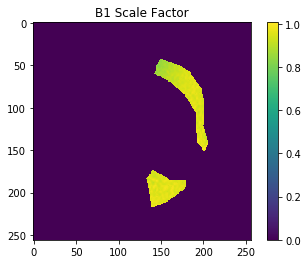

In [195]:
plt.imshow(b1scale_image);
plt.title('B1 Scale Factor');
plt.colorbar()
#plt.savefig('png_images/muscle_pulse_angle_image.png')

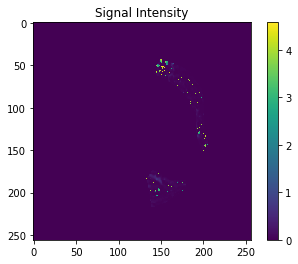

In [196]:
plt.imshow(Amuscle_image);
plt.title('Signal Intensity');
plt.colorbar();
#plt.savefig('png_images/muscle_af2_image.png')

In [198]:
print( 'muscle T2 {:6.2f} +/- {:4.2f} ms'.format( epg_vals[:,2].mean(), epg_vals[:,2].std()))

muscle T2  31.69 +/- 6.65 ms


In [200]:
print( 'B1 scale factor {:6.2f} +/- {:4.2f} degrees'.format( epg_vals[:,0].mean(), epg_vals[:,0].std()))

B1 scale factor   0.95 +/- 0.03 degrees
